In [3]:
#Using Healpy to plot icecube data
#Michael Campana Feb 18 2020
import time
from IPython.display import clear_output

In [4]:
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from matplotlib.collections import PatchCollection
import pandas as pd
from scipy.stats import poisson, binom, chi2
from scipy.stats import mode as spmode
from scipy.optimize import minimize
from scipy.interpolate import splrep, splev

In [5]:
#3 year data
#UNITS:
#    MJD days
#    log10E GeV
#    AngErr deg
#    All Angles deg

MJD1, log10E1, AngErr1, RA1, DEC1, Azi1, Zen1 = np.loadtxt('IC79-2010-events.txt', unpack=True)
MJD2, log10E2, AngErr2, RA2, DEC2, Azi2, Zen2 = np.loadtxt('IC86-2011-events.txt', unpack=True)
MJD3, log10E3, AngErr3, RA3, DEC3, Azi3, Zen3 = np.loadtxt('IC86-2012-events.txt', unpack=True)

print(len(MJD1),len(MJD2),len(MJD3))
MJD = np.concatenate((MJD1,MJD2,MJD3))
log10E = np.concatenate((log10E1,log10E2,log10E3))
AngErr = np.concatenate((AngErr1,AngErr2,AngErr3))
RA = np.concatenate((RA1,RA2,RA3))
DEC = np.concatenate((DEC1,DEC2,DEC3))
Azi = np.concatenate((Azi1,Azi2,Azi3))
Zen = np.concatenate((Zen1,Zen2,Zen3))
print(len(MJD), len(MJD1)+len(MJD2)+len(MJD3))

93133 136244 105300
334677 334677


<b>EVENT MAPS</b>

In [4]:
def PlotMollviewLocal(title,ZenArr,AziArr,nside=64,rot=None):
    #Plots mollweide projection of local coords in degrees
    nside = nside
    npix = hp.nside2npix(nside)
    map_ind = hp.ang2pix(nside,np.radians(ZenArr),np.radians(AziArr))
    ind, count = np.unique(map_ind, return_counts=True)
    hpx_map = np.zeros(npix, dtype=int)
    hpx_map[ind] = count
    
    plt.figure()
    hp.mollview(hpx_map, unit='Counts', title=title, rot=rot, margins=(1,1,1,1)) 
    hp.graticule(30, color='w', alpha=0.7)
    
    hp.projtext(0,0,'0', size='large', ha='center', va='bottom')
    hp.projtext(np.pi/2,0,'0', size='large', ha='left')
    hp.projtext(np.pi/2,2*np.pi - .001,'360', size='large', ha='right')
    hp.projtext(np.pi,0,'180', size='large', ha='center', va='top')
    
    plt.title(title, pad=25)
    plt.show()


In [5]:
def PlotMollviewEqui(title,DecArr,RaArr,nside=64,rot=None,coord=None):
    #Plots mollweide projection of equitorial coords in degrees
    nside = nside
    npix = hp.nside2npix(nside)
    map_ind = hp.ang2pix(nside,np.pi/2.0 - np.radians(DecArr),np.radians(RaArr))
    ind, count = np.unique(map_ind, return_counts=True)
    hpx_map = np.zeros(npix, dtype=int)
    hpx_map[ind] = count
    
    plt.figure()
    hp.mollview(hpx_map, unit='Counts', title=title, rot=rot, margins=(1,1,1,1), coord=coord) 
    hp.graticule(30, color='w', alpha=0.7)
    
    hp.projtext(0,0,'90', size='large', ha='center', va='bottom', coord=coord)#, rot=rot)
    hp.projtext(np.pi/2,2.0*np.pi - .001,'360', size='large', ha='right', coord=coord)#, rot=rot)
    hp.projtext(np.pi/2,0,'0', size='large', ha='left', coord=coord)#, rot=rot)
    hp.projtext(np.pi,0,'-90', size='large', ha='center', va='top', coord=coord)#, rot=rot)
    
    plt.title(title, pad=25)
    plt.show()


<b>ANALYSES</b>

In [6]:
#Getting RA and DEC coords of each pixel, along with the counts per pixel
def AngAndCountPerPixEqui(DEC,RA,nside=64,rot=None,coord=None):
    nside = nside
    npix = hp.nside2npix(nside) #Number of pixels (Number of bins)
    #print(npix)
    pix_nums_list = np.arange(npix) #List of possible pixel numbers for npix total pixels
    pix_num = hp.ang2pix(nside,np.pi/2.0 - np.radians(DEC),np.radians(RA)) #Pixel number for each event
    pix_nums, pix_counts = np.unique(pix_num, return_counts=True)  #Pixel numbers and counts of each pixel 
    #The above line will create arrays with pix_nums that have greater than 0 counts...we need to include all
    #We will create two data frames, one for the possible pixel numbers,
    #...and one for the unique pixel numbers and counts,
    #...and then merge them on pixel numbers, and replace NaN with 0 counts
    num_list_df = pd.DataFrame(pix_nums_list)
    num_list_df.columns = ['pix_num']
    
    unique_nums_counts_df = pd.DataFrame(pix_nums)
    unique_nums_counts_df.columns = ['pix_num']
    unique_nums_counts_df['pix_count'] = pix_counts
    
    pix_lat, pix_lon = hp.pix2ang(nside, pix_nums_list) #latitude and longitude of possible pixel number
    pix_dec = np.pi/2 - pix_lat #DEC from latitude
    pix_ra = pix_lon            #RA from longitude
    #print(pix_dec)
    num_list_df['RA'] = pix_ra
    num_list_df['DEC'] = pix_dec
    
    #Dataframe containing all possible pixel numbers with their respective RA,DEC and counts
    nums_counts_ra_dec_df = num_list_df.merge(unique_nums_counts_df, on='pix_num',how='outer')
    nums_counts_ra_dec_df.fillna(0.0, inplace=True)
    #display(nums_counts_ra_dec_df)
    
    decs = nums_counts_ra_dec_df['DEC'].to_numpy(copy=True, dtype=np.float64)
    ras = nums_counts_ra_dec_df['RA'].to_numpy(copy=True, dtype = np.float64)
    counts = nums_counts_ra_dec_df['pix_count'].to_numpy(copy=True, dtype=np.float64)
    pixels = nums_counts_ra_dec_df['pix_num'].to_numpy(copy=True, dtype=np.float64)
    
    return nums_counts_ra_dec_df, decs, ras, counts, pixels

In [7]:
def BinnedPvalAnalysisEqui(decs,ras,counts,nside=64):
    unique_decs = np.unique(decs)
    unique_decs = np.flip(unique_decs)

    dec_bin_counts = {} #Dictionary to hold list of counts per bin in each declination band

    #Create dictionary to hold a list of counts for each bin in the labeled declination band
    for pixdec in unique_pix_decs:
        dec_bin_counts[pixdec] = pixelCountList[np.nonzero(decs == pixdec)]
    
    #for i in range(len(unique_decs)):
    #    band_counts_per_bin = []
    #    for j in range(len(decs)):
    #        if decs[j] == unique_decs[i]:
    #            band_counts_per_bin.append(counts[j])
    #    dec_bin_counts[unique_decs[i]] = band_counts_per_bin
    
    #Create Dictionary of lists of pvalues per bin in each band, keyed by declination of each band
    #And dictionary of dec band count averages
    #And dictionary of dec band mins, and of maxes
    #And median
    dec_bin_pvals = {}
    dec_band_count_avg = {}
    dec_band_count_min = {}
    dec_band_count_max = {}
    dec_band_count_med = {}
    for d in unique_decs:
        bin_count_list = dec_bin_counts[d]
        band_count_avg = np.mean(bin_count_list, dtype=np.float64)
        band_count_max = np.max(bin_count_list)
        band_count_min = np.min(bin_count_list)
        band_count_med = np.median(bin_count_list)
        band_pval_per_bin = poisson.sf(bin_count_list, band_count_avg)
        
        dec_bin_pvals[d] = band_pval_per_bin
        dec_band_count_avg[d] = band_count_avg
        dec_band_count_min[d] = band_count_min
        dec_band_count_max[d] = band_count_max
        dec_band_count_med[d] = band_count_med

    pvals = [item for sublist in list(dec_bin_pvals.values()) for item in sublist] #Flatten

    #print(min(pvals))
    #print(max(pvals))
    #print(np.mean(pvals))
    #print(len(pvals))
    
    return pvals, dec_bin_counts, dec_band_count_avg, dec_band_count_min, dec_band_count_max, dec_bin_pvals, dec_band_count_med


In [8]:
def BinomialPvalAnalysisEqui(eventDecList, pixelRAList, pixelDecList, pixelCountList, maxDelDec, minDelDec, nside = 64, sig_count_adjust = False):
    #Using Binomial statistics to compare each bin to events in its respective solid angle declination band
    #...rather than comparing each bin to each other bin with the same declination
    #We will obtain counts for a band of declination defined by pixel centers +/- some deltaDec in rads
    DEC_rad = np.radians(eventDecList)
    
    dec_band_counts = {}
    
    #Unique decs for pixels
    unique_pix_decs, pixels_per_dec = np.unique(pixelDecList, return_counts=True)
    unique_pix_decs = np.flip(unique_pix_decs)
    #print('-------------UNIQUE PIXEL DECS--------------')
    #print(unique_pix_decs)
    
    #Varying deltaDec as we move away from dec=0
    q = complex(0,len(unique_pix_decs[unique_pix_decs >= np.pi/6]))
    p = len(unique_pix_decs[(unique_pix_decs < np.pi/6) & (unique_pix_decs > -np.pi/6)])
    v = complex(0,len(unique_pix_decs[unique_pix_decs <= -np.pi/6]))
    
    deltaDec = np.r_[maxDelDec:minDelDec:q, [minDelDec]*p, minDelDec:maxDelDec:v]
    #print(len(deltaDec), len(unique_pix_decs))
    #print('------------HALF BAND WIDTHS------------')
    #print(deltaDec)
    
    #Dictionary to hold number of events in defined dec band
    for upd, dD in zip(unique_pix_decs, deltaDec):
        dec_band_counts[upd] = len(DEC_rad[(DEC_rad >= upd - dD) & (DEC_rad < upd + dD)])
    
    #Dictionary to hold list of counts per bin in each declination band for plotting's sake
    #And also RA values for those bins
    dec_bin_counts = {} 
    dec_bin_ras = {}
    #Fill dictionary...
    for d in unique_pix_decs:
        dec_bin_counts[d] = pixelCountList[np.nonzero(pixelDecList == d)]
        dec_bin_ras[d] = pixelRAList[np.nonzero(pixelDecList == d)]
    
    #Create Dictionary of lists of pvalues per bin in each band, keyed by declination of each band
    #And dictionary of dec band count averages
    #And dictionary of dec band mins, and of maxes
    #And median
    dec_bin_pvals = {}
    dec_band_count_avg = {}  #Note: Here 'band' refers to pixels with centers at the same dec
    dec_band_count_min = {}
    dec_band_count_max = {}
    dec_band_count_med = {}
    
    pix_solang = hp.nside2pixarea(nside)
    
    for upd, dD in zip(unique_pix_decs, deltaDec):
        bin_count_list = dec_bin_counts[upd]
        band_count_avg = np.mean(bin_count_list, dtype=np.float64)
        band_count_max = np.max(bin_count_list)
        band_count_min = np.min(bin_count_list)
        band_count_med = np.median(bin_count_list)
        
        band_solang = ( np.sin(upd + dD) - np.sin(upd - dD) ) * 2.0 * np.pi 
        bg_prob = pix_solang / band_solang
        
        if sig_count_adjust:
            #Make any count less than the average, equal to the average
            bin_count_list[(bin_count_list / pix_solang) < (dec_band_counts[upd] / band_solang)] = np.rint(dec_band_counts[upd] / band_solang * pix_solang)
        
        band_pval_per_bin = binom.sf(bin_count_list, dec_band_counts[upd], bg_prob)
        
        #Cut out 80 deg to pole (N and S poles)
        if upd >= 1.4 or upd <= -1.4:
            dec_bin_pvals[upd] = np.full_like(band_pval_per_bin,np.nan)
        else:
            dec_bin_pvals[upd] = band_pval_per_bin
        
        #dec_bin_pvals[upd] = band_pval_per_bin
        dec_band_count_avg[upd] = band_count_avg
        dec_band_count_min[upd] = band_count_min
        dec_band_count_max[upd] = band_count_max
        dec_band_count_med[upd] = band_count_med

    pvals = [item for sublist in list(dec_bin_pvals.values()) for item in sublist] #Flatten pvals

    return pvals, dec_band_counts, dec_bin_counts, dec_band_count_avg, dec_band_count_min, dec_band_count_max, dec_bin_pvals, dec_band_count_med, deltaDec, dec_bin_ras

From the Bootcamp example...

For Unbinned LLH:

We will use the following likelihood definition
\begin{equation}
\mathcal{L}(ns) = \prod_{i = 1}^N\left[ \frac{ns}{N} S_{i,c} + (1-\frac{ns}{N}) B \right], \\ B = 1/4\pi, \\ S_{i,c} = S(event_i, source_c)
\end{equation}
where $ns = 0$ is the null hypothesis and is bounded to be between zero and N, $S$ accounts for the event angular distribution, $B$ is the background distribution which we will assume isotropic ($1/4\pi$). N is the total number of events. Go ahead and construct the $\log\mathcal{L}$.

We are going to use the following test statistic (TS) definition<br><br>
\begin{equation}
\mathcal{TS} = 2 * \log( \mathcal{L}(ns) / \mathcal{L}(ns=0) )
\end{equation}<br>
\begin{equation}
\mathcal{TS} = 2 * \sum_{i = 1}^N \log\left[ \frac{ns}{N} \frac{S_{i,c}}{B} + (1-\frac{ns}{N}) \right]
\end{equation}

In [6]:
class UnbinnedLLHAnalysis:
    #Function to compute unbinned likelihood, and TS for log likelihood.
    
    def __init__(self, event_dec_list, event_ra_list, event_angerr_list, source_dec_list, source_ra_list):
        #Use radians for calculations
        #print('start')
        self.edec = event_dec_list
        self.era = event_ra_list
        self.eangerr = event_angerr_list
        self.sdec = source_dec_list
        self.sra = source_ra_list
    
    #Uses a bivariate gaussian distribution for spatial signal distribution.
    #Hence, we are approximating a local region on a sphere to be a flat surface.
    #(for in depth, see https://icecube-spno.slack.com/archives/CA14S7480/p1568135317031700)
    
    #Currently not including Energy...
    def signal_dist(self, source_dec, source_ra):
        #NOTE: This S is for all events, with one source. When using multiple sources, 
        #...will need to loop over the sources; implementing this func once
        #...per source.
        
        expon = -.5 * ( (self.edec - source_dec)**2 + (self.era - source_ra)**2 ) / (self.eangerr)**2
        S = 1.0 / (2.0 * np.pi) / (self.eangerr)**2 * np.exp(expon)
        #print('signal_distribution')
        return S
    
    def background_dist(self, density=True):
        #Obtaining Background Dist

        #sin(dec) bins
        dec_bins = np.unique(np.concatenate([
                                 np.linspace(-1., -0.2, 10 + 1),
                                 np.linspace(-0.2, 0.0, 4 + 1),
                                 np.linspace(0.0, 0.2, 5 + 1),
                                 np.linspace(0.2, 1., 10),
                                 ]))

        bin_centers = []
        for i in range(len(dec_bins)-1):
            bin_centers.append( (dec_bins[i] + dec_bins[i+1]) / 2.0 )

        n, bins = np.histogram(np.sin(self.edec), bins=dec_bins, density=density)
        
        tck = splrep(bin_centers, n/(2.0*np.pi))
        
        B = splev(np.sin(self.edec), tck)
        #print('background_distribution')
        return B
    
    #Now we define the test statistic...
    #For now, we are calculating for a *single source*
    def calc_TS(self, ns, S, B):
        N = len(self.edec) #Total number of events
        
        #One source 
        #source_dec = self.sdec[0]
        #source_ra = self.sra[0]      
        #B = self.background_dist() #Background pdf
        #S = self.signal_dist(source_dec, source_ra) #signal pdf for one source

        log_term = (ns / N) * (S / B) + (1.0 - ns / N)
        
        TS = -2.0 * np.sum(np.log(log_term))
        
        #print('calc_TS')
        return TS
    
    #using scipy.optimize.minimize
    def minimize_TS(self, S, B):
        minTS_res = minimize(self.calc_TS, np.array([1.0]), args=(S,B), bounds=((0.0,len(self.edec)),))
        #print('minimize_TS')
        return minTS_res.x[0], minTS_res.fun     

<b>************PLOTTING************</b>

In [31]:
def plotPvalsEqui(decs,ras,pvals,hotRA,hotDEC, nside=64, coord=None, rot=None, title=None, logvals=False):
    #decs and ras should be in radians for this function
    
    if logvals:
        pvals = -np.log10(pvals)
        mincb = 0.0
        maxcb = None
        unit = '- log10 Pval'
    else:
        mincb = 0.0
        maxcb = 1.0
        unit = 'Pval'
    
    npix = hp.nside2npix(nside)
    map_ind = hp.ang2pix(nside, np.pi/2.0 - decs, ras) 
    ind = np.bincount(map_ind)
    hpx_map = np.zeros(npix, dtype=np.float64)
    hpx_map[np.arange(npix)] = np.array(pvals)
    
    plt.figure(facecolor='w')
    hp.mollview(hpx_map, unit=unit, title=title, rot=rot, margins=(1,1,1,1), coord=coord, min=mincb,max=maxcb, cmap='coolwarm') 
    hp.graticule(30, color='w', alpha=0.7)
    
    hp.projtext(0,0,'90', size='large', ha='center', va='bottom', coord=coord)#, rot=rot)
    hp.projtext(np.pi/2,2.0*np.pi - .001,'360', size='large', ha='right', coord=coord)#, rot=rot)
    hp.projtext(np.pi/2,0,'0', size='large', ha='left', coord=coord)#, rot=rot)
    hp.projtext(np.pi,0,'-90', size='large', ha='center', va='top', coord=coord)#, rot=rot)
    
    hp.projscatter(np.pi/2.0 - hotDEC, hotRA, marker='+', facecolors='black', edgecolors='black', coord=coord)
    
    plt.title(title, pad=25)
    plt.show()


In [10]:
def PlotPixelsPerDec(dec_bin_counts):
    #Getting number of bins in each dec band for binned analysis
    
    dec_num_of_bins = []
    for key in dec_bin_counts.keys():
        dec_num_of_bins.append(len(dec_bin_counts[key]))

    #Plotting num of bins in each dec
    plt.figure(figsize=(8,6), facecolor='w')
    plt.step(list(dec_bin_counts.keys()),dec_num_of_bins)
    plt.xlabel('DEC Band')
    plt.ylabel('Number of pixels')
    plt.show()
    

In [11]:
def PlotPixelCountsPerDec(dec_band_count_avg,dec_band_count_min,dec_band_count_max,dec_band_count_med):
    #Plotting average, min, max Counts in each dec band (pix centers)
    
    plt.figure(figsize=(8,6), facecolor='w')
    plt.step(list(dec_band_count_avg.keys()), list(dec_band_count_avg.values()), label='Mean')
    plt.step(list(dec_band_count_min.keys()), list(dec_band_count_min.values()), label='Min')
    plt.step(list(dec_band_count_max.keys()), list(dec_band_count_max.values()), label='Max')
    plt.step(list(dec_band_count_med.keys()), list(dec_band_count_med.values()), label='Median')
    plt.xlabel('DEC Band')
    plt.ylabel('Counts per Bin')
    plt.legend()
    plt.show()


In [12]:
def PlotPvalPerDecBand(decs, dec_bin_pvals):
    #Plotting Median, Mean pval per dec band (pixel centers)
    
    unique_decs = np.flip(np.unique(decs))

    dec_band_mean_pval = {}
    dec_band_median_pval = {}
    for d in unique_decs:
        band_pvals = dec_bin_pvals[d]
        band_mean_pval = np.mean(band_pvals)
        band_median_pval = np.median(band_pvals)
        dec_band_mean_pval[d] = band_mean_pval
        dec_band_median_pval[d] = band_median_pval

    plt.figure(figsize=(8,6), facecolor='w')
    plt.step(list(dec_band_median_pval.keys()), list(dec_band_median_pval.values()), label='Median')
    plt.step(list(dec_band_mean_pval.keys()), list(dec_band_mean_pval.values()), label='Mean')
    plt.xlabel('DEC Band')
    plt.ylabel('P-value')
    plt.ylim(0.0,1.0)
    
    plt.hlines(0.5,-1.5,1.5,linestyle='--')
    
    plt.legend()
    plt.show()
    

In [13]:
def PlotBandWidths(decs,deltaDec):
    #Band width per declination (pixel centers)
    
    unique_pix_decs = np.unique(decs)
    unique_pix_decs = np.flip(unique_pix_decs)
    plt.step(np.degrees(unique_pix_decs), np.degrees(deltaDec))
    plt.ylabel('Half Band Width')
    plt.xlabel('Dec Band Center')
    plt.show()

In [14]:
def PlotCountsPerDecBand(dec_band_counts):
    #Event counts per declination band
    
    plt.figure(figsize=(8,6), facecolor='w')
    plt.step(list(dec_band_counts.keys()), list(dec_band_counts.values()))
    plt.ylabel('Event Counts')
    plt.xlabel('DEC Band Center')
    plt.show()

In [15]:
def PlotPvalsOneDec(ras, pvals, counts):
    #For plotting the pvalues across a single declination
    #given the respective ras,pvals,counts for the pixels in that dec band
    
    meanpv = np.mean(pvals)
    medpv = np.median(pvals)
    maxpv = np.max(pvals)
    minpv = np.min(pvals)
    modepv = spmode(pvals)
    
    ras = np.degrees(ras)
    
    modect = spmode(counts)
    
    fig, ax1 = plt.subplots(figsize=(16,6))
    
    color='r'
    ax1.step(ras,pvals, color=color)
    line1 = ax1.hlines(meanpv,0,360, label='Mean Pval', color='g')
    line2 = ax1.hlines(maxpv,0,360, label='Max & Min Pval', color=color, linestyle='--')
    ax1.hlines(minpv,0,360, color=color, linestyle='--')
    line3 = ax1.hlines(modepv[0],0,360, color=color, linestyle='dashdot', label='Mode Pval')
    #ax1.hlines(medpv,0,2*np.pi, label='Median Pval', color='g', linestyle='-.')
    line4 = ax1.hlines(0.5,0,360, label='Pval=0.5', linestyle='dotted')
    ax1.set_ylabel('P-value', color=color)
    ax1.set_xlabel('RA [deg]')
    ax1.tick_params(axis='y', labelcolor=color)
    #ax1.legend()
    
    ax2 = ax1.twinx()
    color = 'b'
    ax2.step(ras,counts, color=color)
    ax2.set_ylabel('Count', color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    line5 = ax2.hlines(modect[0],0,360, color=color, linestyle='dashdot', label='Mode Count')
    #ax2.legend()
    
    lns = (line1,line2,line3,line4,line5)
    labs = [l.get_label() for l in lns]
    
    ax1.legend(lns,labs)
    plt.title('Declination ~10 deg')
    fig.tight_layout()
    plt.show()

In [16]:
def HistPvalsCountsOneDec(pvals,counts):
    #For plotting a histogram of the pixel counts in a single declination (pixel centers)
    
    nbin=64 #number of bins
    
    plt.figure(figsize=(16,6), facecolor='w')
    
    plt.subplot(1,2,1)
    plt.hist(pvals,bins=nbin)
    plt.xlabel('P-value')
    
    plt.subplot(1,2,2)
    plt.hist(counts,bins=nbin)
    plt.xlabel('Event Counts per Pixel')
    
    plt.show()

In [21]:
def PlotPointsNearSource(event_ras, event_decs, event_errs, signal_weights, target_ra, target_dec, target_name, vmax=0.3):
    #Plot events with error circles, colored by signal distribution value
    #Puts an 'x' at the source point (written for single source point)
    #Takes all angles/errors in degrees, for visualization convenience
    
    fig, ax = plt.subplots()

    plt.scatter(target_ra, target_dec, label=target_name, marker='x', c='k')
    scat1 = plt.scatter(event_ras, event_decs, label='Data', c=signal_weights, cmap='plasma', vmin=0.0, vmax=vmax)

    colors = scat1.to_rgba(signal_weights)
    #print(colors)

    patches = []
    for i in range(len(event_ras)):
        patches.append( Circle( (event_ras[i], event_decs[i]), radius=event_errs[i] ) )


    patchCollection = PatchCollection(patches, edgecolors=colors, facecolors='none')
    ax.add_collection(patchCollection)


    plt.legend()
    plt.colorbar(label='Normalized Signal Probability')
    plt.xlabel('RA [deg]')
    plt.ylabel('DEC [deg]')
    plt.axis('square')
    
    ax.set_xlim(ax.get_xlim()[::-1])
    
    plt.grid(True)
    plt.tight_layout()
    
    ax.set_axisbelow(True)
    plt.show()

In [62]:
def PlotTSandChi2(TSs, num_trials):
    #Assumes TS = - 2 * LLHR

    #Plotting TS distributions for many trials
    plt.figure(figsize=(16,4), facecolor='w')

    #Fraction of TS that are != 0
    TS_frac = np.mean(TSs < 0)
    print('Fraction of TS < 0 :', TS_frac)

    #Median TS
    TS_med = np.median(TSs)
    print('Median TS: ', TS_med)

    plt.subplot(1,2,1)
    plt.hist(-TSs, bins=50, density=False)
    plt.semilogy()
    plt.ylabel('Trial Count')
    plt.xlabel('TS (2*LLHR)')
    plt.title('{} Trials, TS'.format(num_trials))

    #Fitting chi2 to -TS > 0
    plt.subplot(1,2,2)
    n, bins, patches = plt.hist(-TSs, bins=50, density=True)

    df, loc, scale = chi2.fit(-TSs[TSs < 0])
    print('Chi2 Fit DoF: ', df)
    print('Chi2 Fit loc: ', loc)
    print('Chi2 Fit scale: ', scale)

    xs = np.arange(0.001,np.max(bins),0.01)

    plt.plot(xs, TS_frac*chi2.pdf(xs, df, loc=loc, scale=scale), label='TS > 0 Chi2 Fit: dof={}'.format(np.round(df, decimals=2)))
    plt.vlines(TS_med, 0.0, np.max(n), label='Median TS', colors='r')
    plt.title('{} Trials, TS, eta = {} '.format(num_trials, TS_frac))
    plt.xlabel('TS (2*LLHR)')
    plt.ylabel('Normalized Trial Count')
    plt.semilogy()
    plt.legend()

    plt.show()

<b>RUNNING TRIALS</b>

In [25]:
#Values for use in following functions

nside_choice = 32

#Min and max band width---------------------------------
minDelDec_choice = np.radians(1.0) #This is half the band width
maxDelDec_choice = np.radians(2.5)

print(np.degrees(hp.nside2resol(nside_choice)))

#Number of scrambles------------------------------------
num_trials = 1000

#For Crab Nebula------------------------------------------
cnpix = hp.ang2pix(nside_choice, np.pi/2 - np.radians(22.01), np.radians(83.63))

#For setting counts less than dec avg count to the avg count, use True
sig_count_adjust = True
#print(hp.nside2pixarea(nside_choice)

#***UNBINNED LLH******---------------------------------------
#GC Coords in radians
GC_dec = np.array([-0.506])
GC_ra = np.array([4.650])

1.8322594196359498


In [27]:
start_time = time.clock()
#Lists for holding values for each scramble--------------------------
#hot_pvals = []
#hot_counts = []
#hot_decs = []
#hot_ras = []
#hot_pix = []
#CN_pvals = []
#CN_counts = []

#Unbinned holding lists---------------
TS_list = []
ns_list = []

#**************** Now, for scrambles, use this loop: **************************
for scram in range(num_trials):
    #First pass, no scramble, use data
    if scram == 0:
        RA_use = RA
    else:
        RA_use = 360 * np.random.random(len(RA))
    
#Event maps------------------------------------------------
    #PlotMollviewLocal('All-Sky Point Source 2010-2012 (Local Coords)',Zen,Azi, nside=32, rot=(180,0,0))
    #PlotMollviewEqui('All-Sky Point Source 2010-2012 (Equitorial Coords)',DEC,RA, nside=nside_choice,coord='C', rot=(180,0,0))

#Binned Analyses-------------------------------------------
    #nums_counts_ra_dec_df, decs, ras, counts, pixels = AngAndCountPerPixEqui(DEC,RA_use, nside=nside_choice)
    #pvals, dec_bin_counts, dec_band_count_avg, dec_band_count_min, dec_band_count_max, dec_bin_pvals, dec_band_count_med = BinnedPvalAnalysisEqui(decs,ras,counts,nside=nside_choice)
    #pvals, dec_band_counts, dec_bin_counts, dec_band_count_avg, dec_band_count_min, dec_band_count_max, dec_bin_pvals, dec_band_count_med, deltaDec, dec_bin_ras = BinomialPvalAnalysisEqui(DEC, ras, decs, counts, maxDelDec=maxDelDec_choice, minDelDec=minDelDec_choice, nside=nside_choice, sig_count_adjust = sig_count_adjust)
    #nums_counts_ra_dec_df['pval'] = pvals
    #display(nums_counts_ra_dec_df)

    #For plots
    #nums_counts_ra_dec_df.sort_values(by='pval', inplace=True)

    #For scrambles
    #hottestPVAL = nums_counts_ra_dec_df.iloc[0,4]
    #hottestCOUNT = nums_counts_ra_dec_df.iloc[0,3]
    #hottestDEC = nums_counts_ra_dec_df.iloc[0,2]
    #hottestRA = nums_counts_ra_dec_df.iloc[0,1]
    #hottestPIX = nums_counts_ra_dec_df.iloc[0,0]

    #CNCOUNT = nums_counts_ra_dec_df.loc[cnpix,'pix_count']
    #CNPVAL = nums_counts_ra_dec_df.loc[cnpix,'pval']

    #After scrambling, add hottest pval and respective counts to lists for plotting later...
    #...The 0th element in each list is the value for actual data
    #hot_pvals.append(hottestPVAL)
    #hot_counts.append(hottestCOUNT)
    #hot_decs.append(hottestDEC)
    #hot_ras.append(hottestRA)
    #hot_pix.append(hottestPIX)
    
    #CN_pvals.append(CNPVAL)
    #CN_counts.append(CNCOUNT)
    
#Unbinned LLH Analysis-------------------------------------

    GC_LLH = UnbinnedLLHAnalysis(np.radians(DEC), np.radians(RA_use), np.radians(AngErr), GC_dec, GC_ra)
    S = GC_LLH.signal_dist(GC_dec, GC_ra)
    B = GC_LLH.background_dist(density=True)
    bf_ns, TS = GC_LLH.minimize_TS(S, B)
    
    if scram == 0:
        #For plotting using Signal Distribution (applies to num_trials = 0, i.e. data)
        dataS_dist = np.copy(S)
        dataS_norm = dataS_dist / np.sum(dataS_dist)
      
    #Add ns and TS per trial to list for holding. 0th entry in each list is data...
    ns_list.append(bf_ns)
    TS_list.append(TS)
       
    clear_output(wait=True)
    display(scram)
    
#********************************** End of Loop ****************************************

#Location of 5 hottest pixels------------------------------
#hottestRA = nums_counts_ra_dec_df.iloc[0:5,1].to_numpy(copy=True)
#hottestDEC = nums_counts_ra_dec_df.iloc[0:5,2].to_numpy(copy=True)
#print(hottestRA)
#print(hottestDEC)

#Choice for plotting one band pvals--------------------------
#dec_choice = decs[np.argmin(np.abs(decs-np.radians(10)))]
#print('dec choice = ', dec_choice)
#display(nums_counts_ra_dec_df)

#Plotting Funcs------------------------------------------------------------------------
#plotPvalsEqui(decs,ras,pvals,hottestRA,hottestDEC, coord='C', title='Pvalues',rot=(180,0,0), nside=nside_choice, logvals=True)
#PlotPixelsPerDec(dec_bin_counts)
#PlotPixelCountsPerDec(dec_band_count_avg,dec_band_count_min,dec_band_count_max,dec_band_count_med)
#PlotPvalPerDecBand(decs, dec_bin_pvals)
#PlotCountsPerDecBand(dec_band_counts)
#PlotBandWidths(decs,deltaDec)
#PlotPvalsOneDec(dec_bin_ras[dec_choice], dec_bin_pvals[dec_choice], dec_bin_counts[dec_choice])
#HistPvalsCountsOneDec(dec_bin_pvals[dec_choice], dec_bin_counts[dec_choice])

#Converting dataframe values to degrees and displaying DF sorted by pvals for viewing--------------
#nums_counts_ra_dec_df['RA'] = nums_counts_ra_dec_df['RA'].map(lambda RA: np.degrees(RA))
#nums_counts_ra_dec_df['DEC'] = nums_counts_ra_dec_df['DEC'].map(lambda DEC: np.degrees(DEC))
#display(nums_counts_ra_dec_df)

print("--- %s seconds ---" % (time.clock() - start_time))

999

--- 112.703125 seconds ---


In [28]:
#Making lists into arrays...

#hot_pvals = np.array(hot_pvals)
#hot_counts = np.array(hot_counts)
#hot_decs = np.array(hot_decs)
#CN_pvals = np.array(CN_pvals)
#CN_counts = np.array(CN_counts)
ns_arr = np.array(ns_list)
TS_arr = np.array(TS_list)

In [19]:
#Dataframe for unbinned analysis, Data run
unbinned_df = pd.DataFrame(dataS_norm)
unbinned_df.columns = ['S_norm']
unbinned_df['RA'] = RA
unbinned_df['DEC'] = DEC
unbinned_df['AngErr'] = AngErr

unbinned_df.sort_values(by='S_norm', ascending=False, inplace=True)
display(unbinned_df)

print("GC RA: ", np.degrees(GC_ra[0]), "///", "GC DEC: ", np.degrees(GC_dec[0]))

,S_norm,RA,DEC,AngErr
232688,0.259025,266.2917,-29.1967,0.1631
307684,0.147863,266.3197,-29.2983,0.2413
322137,0.084711,266.2528,-29.3594,0.2307
160969,0.068141,266.0317,-29.0222,0.4670
165853,0.038460,266.6606,-29.5454,0.5527
...,...,...,...,...
114094,0.000000,154.7919,7.2830,1.2493
114093,0.000000,147.3471,-2.5883,1.0290
114092,0.000000,320.9693,-5.2661,0.3275
114091,0.000000,217.2838,-10.7461,0.2859


GC RA:  266.4253747358328 /// GC DEC:  -28.991664433619654


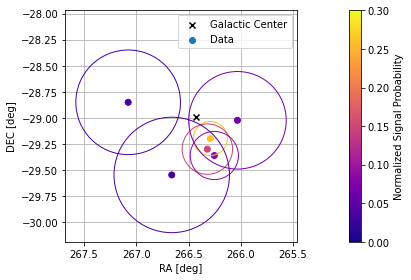

In [22]:
#Plotting nearest events to galactic center
topRA = unbinned_df.iloc[0:6,1].to_numpy(copy=True)
topDEC = unbinned_df.iloc[0:6,2].to_numpy(copy=True)
topERR = unbinned_df.iloc[0:6,3].to_numpy(copy=True)
topS = unbinned_df.iloc[0:6,0].to_numpy(copy=True)

target_ra = np.degrees(GC_ra[0])
target_dec = np.degrees(GC_dec[0])
target_name = 'Galactic Center'
vmax = 0.3

PlotPointsNearSource(topRA, topDEC, topERR, topS, target_ra, target_dec, target_name, vmax=vmax)


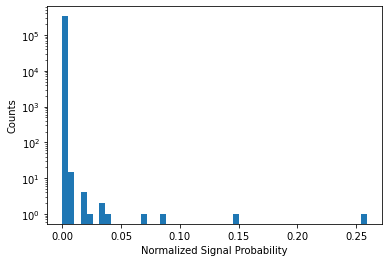

<Figure size 432x288 with 0 Axes>

In [19]:
plt.hist(dataS_norm,bins=50)
plt.xlabel('Normalized Signal Probability')
plt.ylabel('Counts')
plt.yscale('log')

plt.show()
plt.clf()

In [65]:
#Trial Correction for binned pvalues, and Crab Nebula bin--------------

hottest_corrected_pval = len(hot_pvals[hot_pvals < hot_pvals[0]]) / num_trials
CN_corrected_pval = len(CN_pvals[CN_pvals < CN_pvals[0]]) / num_trials

print('Pre-trial Hottest P-value:', hot_pvals[0])
print('Corrected Hottest P-value:', hottest_corrected_pval)
print('Pre-trial CN P-value:', CN_pvals[0])
print('Corrected CN P-value:', CN_corrected_pval)

#Crab Nebula Injection: How many events to get it to *2* sigma ?--------
#We will estimate a normal dist, so 2 sigma for one-tail is the pvalue that is lower than 97.8% of the trials...
#...and find the counts that gives this pvalue
#We start by constructing a dataframe for counts and pvalues of trials
scram_CN_df = pd.DataFrame(CN_pvals)
scram_CN_df.columns = ['Pval']
scram_CN_df['Pix Count'] = CN_counts

#Location of 2sigma pvalue after sorting---------
twoSigLoc = num_trials - int(np.rint(0.978 * num_trials))

scram_CN_df.sort_values(by='Pval', inplace=True)
display(scram_CN_df)
print('-------Two Sigma--------')
display(scram_CN_df.iloc[twoSigLoc])
print('--------CN Data---------')
display(scram_CN_df.loc[0])

CN_2sig_pval = scram_CN_df.iloc[twoSigLoc,0]

Pre-trial Hottest P-value: 0.00010806663336272317
Corrected Hottest P-value: 0.817
Pre-trial CN P-value: 0.4865569927248802
Corrected CN P-value: 0.512


,Pval,Pix Count
541,0.000327,53
985,0.000938,51
908,0.002505,49
437,0.003985,48
637,0.006224,47
...,...,...
443,0.486557,26
445,0.486557,29
447,0.486557,28
449,0.486557,25


-------Two Sigma--------


Pval          0.021178
Pix Count    44.000000
Name: 161, dtype: float64

--------CN Data---------


Pval          0.486557
Pix Count    32.000000
Name: 0, dtype: float64

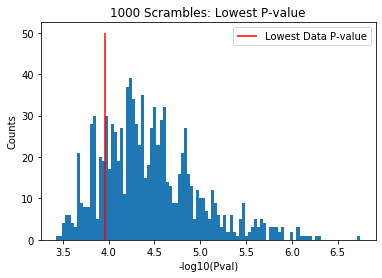

In [72]:
#Plotting lowest p-value distr for binned analysis scrambles...

n,e,p = plt.hist(-np.log10(hot_pvals), bins=100)
plt.vlines(-np.log10(hot_pvals[0]),0,50, color='r', label='Lowest Data P-value')

#plt.hist(hot_pvals, bins=100)
#plt.vlines(hot_pvals[0],0,50, color='r', label='Lowest Data P-value')

plt.xlabel('-log10(Pval)')
plt.ylabel('Counts')
plt.title('{} Scrambles: Lowest P-value'.format(num_trials))
#plt.yscale('log')
plt.legend()
plt.show()

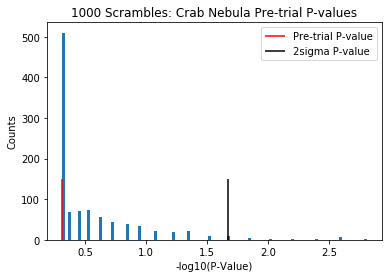

In [47]:
#Crab Nebula binned p-values for scrambles...

plt.hist(-np.log10(CN_pvals), bins=100)
plt.vlines(-np.log10(CN_pvals[0]),0,150, color='r', label='Pre-trial P-value')
#plt.vlines(-np.log10(CN_corrected_pval),0,150, color='g', label='Corrected P-value')
plt.vlines(-np.log10(CN_2sig_pval),0,150, color='k', label='2sigma P-value')

#plt.hist(CN_pvals, bins=100)
#plt.vlines(CN_pvals[0],0,150, color='r', label='Pre-trial P-value')
#plt.vlines(CN_corrected_pval,0,150, color='g', label='Corrected P-value')
#plt.vlines(CN_2sig_pval,0,150, color='k', label='2sigma P-value')

plt.xlabel('-log10(P-Value)')
plt.ylabel('Counts')
#plt.yscale('log')
plt.title('{} Scrambles: Crab Nebula Pre-trial P-values'.format(num_trials))
plt.legend()
plt.show()

Fraction of TS < 0 : 0.296
Median TS:  0.0
Chi2 Fit DoF:  0.7562232175998573
Chi2 Fit loc:  3.3926274746395536e-05
Chi2 Fit scale:  1.607921391179301


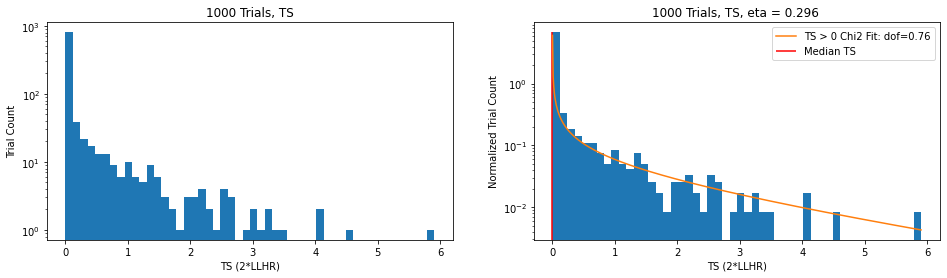

In [63]:
PlotTSandChi2(TS_arr, num_trials)

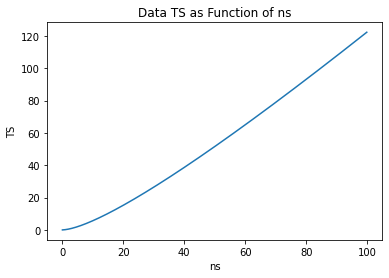

In [15]:
nss = np.arange(0.0,100,.1)
ys = []
for ns in nss:
    ys.append(GC_LLH.calc_TS(ns,S,B))
plt.plot(nss, ys)
plt.xlabel('ns')
plt.ylabel('TS')
plt.title('Data TS as Function of ns')
plt.show()